# Descriptive Mapping of ABM Data

In [1]:
!pip install plotly wordcloud

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud

In [3]:
# load data
df = pd.read_excel("Coded_data.xlsx", header=0)

print("Data shape:", df.shape)

# View all column names
print("\nColumn names:")
print(df.columns.tolist())

Data shape: (45, 30)

Column names:
['Paper ID', 'Authors', 'Year', 'Title', 'Journal/Source', 'Study Type', 'Sustainable Finance Domain', 'Financial Context', 'ESG Dimensions', 'EU Taxonomy Categories-Alignment', 'Taxonomy Compliance Indicators', 'Sustainability Classification Rationale', 'Agent Types', 'Agent Design', 'Interaction Mechanisms', 'Network Structure', 'Time Horizon', 'Validation Method', 'ABM Tool Used', 'Methodological Approach', 'Key Sustainability Metrics', 'Policy Focus', 'Findings', 'Policy Implications', 'Methodological Contributions', 'Limitations', 'Country/Region', 'Data Sources', 'Research Gaps', 'Quality Score']


## RQ1

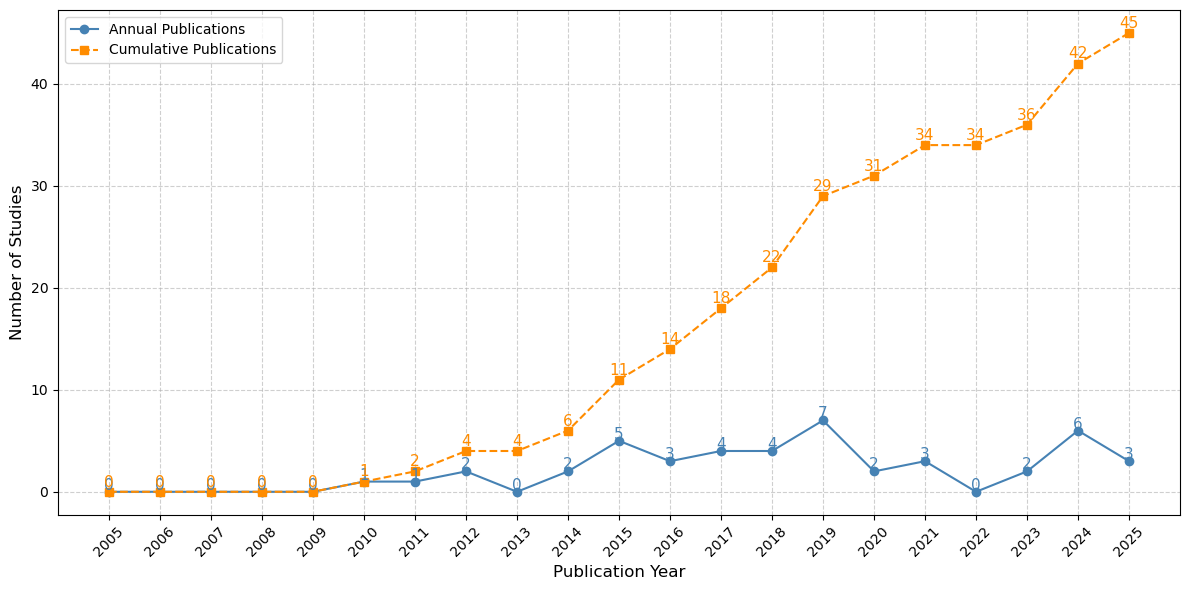

In [4]:

# Search timeline
years = list(range(2005, 2026))

# Count included studies per year
pub_counts = df['Year'].value_counts().sort_index()

# Reindex to include all years in the search range, filling missing with 0
pub_counts = pub_counts.reindex(years, fill_value=0)

# Compute cumulative counts
cumulative_counts = pub_counts.cumsum()

# Plot both trends
plt.figure(figsize=(12,6))

# Annual publications
plt.plot(pub_counts.index, pub_counts.values, marker='o', linestyle='-', color="steelblue", label="Annual Publications")

# Annotate annual publications
for x, y in zip(pub_counts.index, pub_counts.values):
    plt.text(x, y+0.2, str(y), ha='center', fontsize=11, color="steelblue")

# Cumulative publications
plt.plot(cumulative_counts.index, cumulative_counts.values, marker='s', linestyle='--', color="darkorange", label="Cumulative Publications")

# Annotate cumulative publications
for x, y in zip(cumulative_counts.index, cumulative_counts.values):
    plt.text(x, y+0.5, str(y), ha='center', fontsize=11, color="darkorange")

# Formatting
plt.xlabel("Publication Year", fontsize=12)
plt.ylabel("Number of Studies", fontsize=12)
#plt.title("Publication Trends of Included Studies (2005–2025)", fontsize=14)
plt.xticks(pub_counts.index, rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig("publication_trend.png", dpi=300, bbox_inches="tight")
plt.show()


In [5]:
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "notebook_connected"

# Clean minimal whitespace
df2 = df.copy()
for col in ["Sustainable Finance Domain", "ESG Dimensions", "EU Taxonomy Categories-Alignment"]:
    df2[col] = df2[col].astype(str).str.strip()

# Exact categories & order 
domains   = ["Climate Finance", "Green Finance", "Impact Investing", "Energy Finance", "Governance", "Multiple"]
esg       = ["Environmental", "Social", "Governance", "Mixed"]
taxonomy  = ["Taxonomy-aligned", "Transition-focused", "ESG collection", "Unclassified"]

#  Per-column counts for labels
dom_counts = df2["Sustainable Finance Domain"].value_counts().reindex(domains, fill_value=0)
esg_counts = df2["ESG Dimensions"].value_counts().reindex(esg, fill_value=0)
tax_counts = df2["EU Taxonomy Categories-Alignment"].value_counts().reindex(taxonomy, fill_value=0)

print("Domain counts:\n", dom_counts)
print("\nESG counts:\n", esg_counts)
print("\nTaxonomy counts:\n", tax_counts)

# Node list with unique internal keys 
node_keys = [f"D|{d}" for d in domains] + [f"E|{e}" for e in esg] + [f"T|{t}" for t in taxonomy]
idx = {k: i for i, k in enumerate(node_keys)}

labels_display = (
    [f"{d} (n={int(dom_counts[d])})" for d in domains] +
    [f"{e} (n={int(esg_counts[e])})" for e in esg] +
    [f"{t} (n={int(tax_counts[t])})" for t in taxonomy]
)

# Fixed positions: three clear columns
def spaced(n):
    return [(i + 0.5) / n if n > 1 else 0.5 for i in range(n)]

x = [0.00] * len(domains) + [0.50] * len(esg) + [1.00] * len(taxonomy)
y = spaced(len(domains)) + spaced(len(esg)) + spaced(len(taxonomy))

# Links (Domain->ESG, ESG->Taxonomy) 
source, target, value, link_colors = [], [], [], []

# Colors for domains
domain_palette = ['#9E7D30', '#43A047', '#1B5E20', '#00897B', '#458B2F', '#56BB6A']
domain_color_map = {d: domain_palette[i % len(domain_palette)] for i, d in enumerate(domains)}

def rgba(hex_color, a=0.55):
    h = hex_color.lstrip('#')
    r = int(h[0:2], 16)
    g = int(h[2:4], 16)
    b = int(h[4:6], 16)
    return f"rgba({r},{g},{b},{a})"

# Domain -> ESG
links_de = (
    df2[df2["Sustainable Finance Domain"].isin(domains) & df2["ESG Dimensions"].isin(esg)]
    .groupby(["Sustainable Finance Domain", "ESG Dimensions"])
    .size()
    .reindex(pd.MultiIndex.from_product([domains, esg]), fill_value=0)
    .reset_index(name="count")
)
links_de.columns = ["Sustainable Finance Domain", "ESG Dimensions", "count"]

for _, r in links_de.iterrows():
    if r["count"] == 0:
        continue
    s = idx[f"D|{r['Sustainable Finance Domain']}"]
    t = idx[f"E|{r['ESG Dimensions']}"]
    source.append(s)
    target.append(t)
    value.append(int(r["count"]))
    link_colors.append(rgba(domain_color_map[r['Sustainable Finance Domain']], 0.6))





# ESG -> Taxonomy 
esg_color_map = {
    "Environmental": "#4169E1",  # Royal Blue
    "Social": "#FFA500",        # Orange
    "Governance": "#DC143C",    # Crimson
    "Mixed": "#7FB3D5"          # Light Blue
}

links_et = (
    df2[df2["ESG Dimensions"].isin(esg) & df2["EU Taxonomy Categories-Alignment"].isin(taxonomy)]
    .groupby(["ESG Dimensions", "EU Taxonomy Categories-Alignment"])
    .size()
    .reindex(pd.MultiIndex.from_product([esg, taxonomy]), fill_value=0)
    .reset_index(name="count")
)
links_et.columns = ["ESG Dimensions", "EU Taxonomy Categories-Alignment", "count"] 
for _, r in links_et.iterrows():
    if r["count"] == 0:
        continue
    s = idx[f"E|{r['ESG Dimensions']}"]
    t = idx[f"T|{r['EU Taxonomy Categories-Alignment']}"]
    source.append(s)
    target.append(t)
    value.append(int(r["count"]))
    link_colors.append(rgba(esg_color_map[r['ESG Dimensions']], 0.55))

#  Node colors
node_colors = []
for k in node_keys:
    p, name = k.split("|", 1)
    if p == "D":
        node_colors.append(domain_color_map[name])
    elif p == "E":
        node_colors.append(esg_color_map[name])
    else:
        node_colors.append({
            "Taxonomy-aligned": "#00B5F0",
            "Transition-focused": "#F4A7B9",
            "ESG collection": "#7FB3D5",
            "Unclassified": "#C8C8C8"
        }[name])

#  Plot 
fig = go.Figure(go.Sankey(
    arrangement="fixed",
    valueformat=".0f",
    node=dict(
        pad=24,
        thickness=20,
        line=dict(color="rgba(0,0,0,0.35)", width=0.6),
        label=labels_display,
        color=node_colors,
        x=x, y=y
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
        hovertemplate="Count: %{value}<extra></extra>"
    )
))

fig.update_layout(
    font=dict(size=12),
    height=620, width=1100,
    margin=dict(l=40, r=40, t=60, b=40)
)
fig.show()

# Save as HTML
fig.write_html("sankey_rq1.html", include_plotlyjs="cdn")


Domain counts:
 Sustainable Finance Domain
Climate Finance      8
Green Finance        7
Impact Investing     2
Energy Finance       5
Governance           6
Multiple            16
Name: count, dtype: int64

ESG counts:
 ESG Dimensions
Environmental    21
Social            2
Governance        7
Mixed            15
Name: count, dtype: int64

Taxonomy counts:
 EU Taxonomy Categories-Alignment
Taxonomy-aligned       7
Transition-focused    12
ESG collection         4
Unclassified          22
Name: count, dtype: int64
